In [12]:
import pandas as pd
from pathlib import Path
import numpy as np

In [55]:
def cm_scores(df, rater1, rater2):
    array = np.zeros((3,3))
    for i,rating_1 in enumerate(['yes', 'maybe', 'no']):
        for j,rating_2 in enumerate(['yes', 'maybe', 'no']):
            value = len(df[(df[rater1] == rating_1) & (df[rater2] == rating_2)])
            array[i,j] = value
    #add the corresponding off diagonal values together
    ym = array[0,1] + array[1,0]
    yn = array[0,2] + array[2,0]
    mn = array[1,2] + array[2,1]
    array[0,1] = ym
    array[1,0] = ym
    array[0,2] = yn
    array[2,0] = yn
    array[1,2] = mn
    array[2,1] = mn
    return array
    #         try:
    #             value = cm.loc[rating_1, rating_2]
    #         except:
    #             print(cm)
    #             value = cm.loc[rating_1, rating_2]
    #         array[i,j] = value
    # return array


root = Path("/fs5/p_masi/kimm58/InterRaterVariability/")

pipelines = ["SLANT-TICVv1.2", "PreQual", "T1w", "TractsegAFright", "TractsegCC4", "TractsegCSTleft", "TractsegSLFIleft", "TractsegTPOTCright"]
raters = ['rater_1', 'rater_2', 'rater_3', 'rater_4']
all_classes = ['yes', 'maybe', 'no']

for pipeline in pipelines:
    pipeline_df = pd.DataFrame()
    for rater in raters:
        #grab the QA csv file
        qa = pd.read_csv(root / rater / pipeline / "QA.csv")
        #concatenate the sub,ses,acq,run columns into a single column
        qa['scan'] = qa['sub'] + "_" + qa['ses'] + "_" + qa['acq'] + "_" + qa['run']
        #grab the columns of QA status and scan only
        qa = qa[['scan', 'QA_status']]
        #rename the QA column to the rater name
        qa = qa.rename(columns={'QA_status': rater})
        #merge the QA column to the pipeline_df
        try:
            pipeline_df = pd.merge(pipeline_df, qa, on='scan', how='outer')
        except:
            pipeline_df = qa
    #change to categorical
    for rater in raters:
        pipeline_df[rater] = pd.Categorical(pipeline_df[rater], categories=all_classes)
        #pipeline_df[raters] = pd.Categorical(pipeline_df[raters], categories=all_classes)
    #create the confusion matrix across all raters
    confusion_dict = {}
    confusiuon_matrix = pd.DataFrame()
    total_cm = np.zeros((3,3))
    for i in range(len(raters)):
        for j in range(i+1, len(raters)):
            cm_values = cm_scores(pipeline_df, raters[i], raters[j])
            total_cm += cm_values
    #make sure that the values are normalized by the total number of scans times the total number of rater comparisons (which is n*(n-1)/2)
    num_raters = len(raters)
    num_comparisons = num_raters*(num_raters-1)/2
    num_scans = len(pipeline_df)
    #total_cm = total_cm / (num_scans*num_comparisons)
    break


Accuracy: 0.9857686579513487


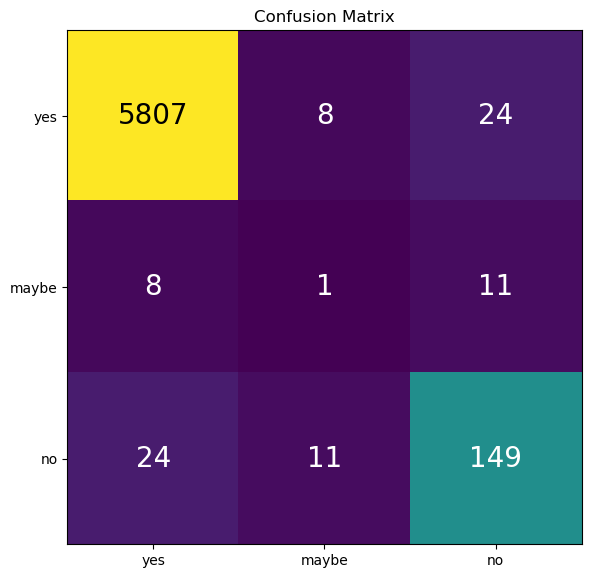

In [59]:
import matplotlib.pyplot as plt

def create_confusion_matrix_plot(cm, classes):
    f,ax = plt.subplots(1,1, figsize=(6,6))
    im = ax.imshow(cm, cmap='viridis', vmax=300)
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(len(classes)):
        for j in range(len(classes)):
            #if cm[i,j] < .8:
            if cm[i,j] < 300:
                color = 'white'
            else:
                color = 'black'
            if cm[i,j] < 0:
                formatted_value = "{:.4f}".format(cm[i, j])
            else:
                formatted_value = int(cm[i, j])
            text = ax.text(j, i, formatted_value, ha="center", va="center", color=color, fontsize=20)
    ax.set_title("Confusion Matrix")
    accuarcy = np.trace(cm) / np.sum(cm)
    #ax.set_xlabel(f"Accuracy: {accuarcy}")
    print(f"Accuracy: {accuarcy}")
    f.tight_layout()
    plt.show()

create_confusion_matrix_plot(total_cm, all_classes)